# MLP

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json
import os

# 1. Load each JSON file for different emotion labels
label_files = {
    0: 'data/anger_filtered.json',
    1: 'data/joy_filtered.json',
    2: 'data/neutral_filtered.json',
    3: 'data/sadness_filtered.json'
}

features = []
labels = []

# Load data and labels from each file
for label, file_path in label_files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        for track, features_dict in data.items():
            if isinstance(features_dict, dict):
                features.append(list(features_dict.values()))
            elif isinstance(features_dict, list):
                features.append(features_dict)
            else:
                raise ValueError(f"Unexpected data format in {file_path}: {features_dict}")
        labels.extend([label] * len(data))

# Convert to numpy array
features = np.array(features)
labels = np.array(labels)

# Fill missing features to make the feature vector 12-dimensional
def pad_features(features, target_features=["tempo", "valence", "energy", "danceability", 
                                             "acousticness", "speechiness", "liveness", 
                                             "instrumentalness", "loudness", "key", "mode", "duration_ms"]):
    padded_features = []
    for feature in features:
        feature_dict = dict(zip(["tempo", "valence", "energy", "danceability", 
                                  "acousticness", "speechiness", "liveness"], feature))
        padded_feature = [feature_dict.get(key, 0) for key in target_features]
        padded_features.append(padded_feature)
    return np.array(padded_features)

# Apply padding to features
padded_features = pad_features(features)

# 2. Normalize data using MaxAbsScaler
scaler = MaxAbsScaler()
normalized_data = scaler.fit_transform(padded_features)

# 3. Define custom Dataset
class AudioFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# 4. Create DataLoader
dataset = AudioFeatureDataset(normalized_data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 5. Calculate class weights and define loss function
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 6. Define the neural network model
class AudioEmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2):
        super(AudioEmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        # Initialize weights with Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# 7. Train the model
input_size = normalized_data.shape[1]  # Input size is now 12
hidden_size1 = 256
hidden_size2 = 128
num_classes = 4

model = AudioEmotionClassifier(input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Learning rate

num_epochs = 600
best_val_f1 = 0
early_stop_count = 0
patience = 20  # Early stopping patience

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

    # Calculate metrics
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, '
          f'Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}')

    # Early stopping
    if epoch_f1 > best_val_f1:
        best_val_f1 = epoch_f1
        early_stop_count = 0
        torch.save(model.state_dict(), 'mlp.pth')  # Save the updated model
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("Training completed. Best F1 Score:", best_val_f1)

# 8. Load the trained model for inference
loaded_model = AudioEmotionClassifier(input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2)
loaded_model.load_state_dict(torch.load('mlp.pth'))
loaded_model.eval()
print("Updated model loaded and ready for inference.")


Epoch [1/600], Loss: 1.6165, Accuracy: 0.2384, F1 Score: 0.2059
Epoch [2/600], Loss: 1.2097, Accuracy: 0.3536, F1 Score: 0.3542
Epoch [3/600], Loss: 1.0170, Accuracy: 0.4980, F1 Score: 0.4974
Epoch [4/600], Loss: 0.8946, Accuracy: 0.5921, F1 Score: 0.5822
Epoch [5/600], Loss: 0.8031, Accuracy: 0.6543, F1 Score: 0.6421
Epoch [6/600], Loss: 0.7616, Accuracy: 0.6583, F1 Score: 0.6487
Epoch [7/600], Loss: 0.7112, Accuracy: 0.7033, F1 Score: 0.6920
Epoch [8/600], Loss: 0.6791, Accuracy: 0.7245, F1 Score: 0.7183
Epoch [9/600], Loss: 0.6435, Accuracy: 0.7139, F1 Score: 0.7039
Epoch [10/600], Loss: 0.6517, Accuracy: 0.7219, F1 Score: 0.7127
Epoch [11/600], Loss: 0.6107, Accuracy: 0.7563, F1 Score: 0.7460
Epoch [12/600], Loss: 0.6116, Accuracy: 0.7391, F1 Score: 0.7289
Epoch [13/600], Loss: 0.6106, Accuracy: 0.7430, F1 Score: 0.7328
Epoch [14/600], Loss: 0.5809, Accuracy: 0.7550, F1 Score: 0.7466
Epoch [15/600], Loss: 0.5724, Accuracy: 0.7510, F1 Score: 0.7460
Epoch [16/600], Loss: 0.5690, Accu

# TabNet

In [9]:
import numpy as np
import json
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

# 1. JSON 데이터 로드 및 확인
# 각 레이블별 JSON 파일 경로
label_files = {
    "anger": 'data/anger.json',
    "joy": 'data/joy.json',
    "neutral": 'data/neutral.json',
    "sadness": 'data/sadness.json'
}

# 데이터와 라벨을 저장할 리스트 초기화
features = []
labels = []

# 데이터 로드 및 확인
for label_name, file_path in label_files.items():
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            if not isinstance(data, dict):  # JSON 구조가 key-value가 아닌 경우 처리
                raise ValueError(f"Unexpected format in {file_path}. Expected dictionary.")
            features.extend(list(data.values()))  # 피처 추가
            labels.extend([label_name] * len(data))  # 해당 라벨 추가
            print(f"Loaded {len(data)} samples for label '{label_name}'")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# numpy array로 변환
features = np.array(features, dtype=np.float32)  # 데이터 타입 명시
labels = np.array(labels)

# 2. 레이블 인코딩 및 데이터 전처리
# 레이블을 숫자로 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 특징 데이터 스케일링 (표준화)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 데이터 로드 확인
print(f"Features shape: {scaled_features.shape}")
print(f"Encoded labels: {np.unique(encoded_labels, return_counts=True)}")

# 3. 학습/검증 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    scaled_features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# 4. TabNet 모델 정의 및 학습
# 모델 초기화
clf = TabNetClassifier(
    n_d=64,  # 모델 차원
    n_a=64,  # Attention 차원
    n_steps=5,  # Decision steps
    gamma=1.5,  # Attention weight
    n_independent=2,  # 독립적 Gated Linear Units
    n_shared=2,  # 공유 Gated Linear Units
    lambda_sparse=1e-3,  # Sparse regularization
    optimizer_fn=torch.optim.Adam,  # 옵티마이저
    optimizer_params=dict(lr=2e-3),  # 학습률
    scheduler_params={"step_size": 50, "gamma": 0.9},  # Learning rate scheduler
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax"  # Feature selection 방식
)

# 모델 학습
clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=200,  # 최대 epoch 수
    patience=20,  # 조기 종료
    batch_size=256,  # 배치 사이즈
    virtual_batch_size=64  # 미니 배치 크기
)

# 5. 모델 저장
clf.save_model("tabnet_audio_emotion")

# 6. 검증 결과 확인
valid_preds = clf.predict(X_valid)
accuracy = np.mean(valid_preds == y_valid)
print(f"Validation Accuracy: {accuracy:.4f}")

# 7. 클래스별 정확도 출력
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_valid, valid_preds, target_names=label_encoder.classes_))


Loaded 444 samples for label 'anger'
Loaded 371 samples for label 'joy'
Loaded 483 samples for label 'neutral'
Loaded 514 samples for label 'sadness'
Features shape: (1812, 7)
Encoded labels: (array([0, 1, 2, 3], dtype=int64), array([444, 371, 483, 514], dtype=int64))


c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.71444 | val_accuracy: 0.42149 |  0:00:00s
epoch 1  | loss: 1.4481  | val_accuracy: 0.47934 |  0:00:01s
epoch 2  | loss: 1.09288 | val_accuracy: 0.5427  |  0:00:01s
epoch 3  | loss: 1.03562 | val_accuracy: 0.56474 |  0:00:02s
epoch 4  | loss: 0.95712 | val_accuracy: 0.57025 |  0:00:02s
epoch 5  | loss: 0.92401 | val_accuracy: 0.56198 |  0:00:03s
epoch 6  | loss: 0.89732 | val_accuracy: 0.57576 |  0:00:04s
epoch 7  | loss: 0.88537 | val_accuracy: 0.58127 |  0:00:04s
epoch 8  | loss: 0.8962  | val_accuracy: 0.57576 |  0:00:05s
epoch 9  | loss: 0.88912 | val_accuracy: 0.60055 |  0:00:05s
epoch 10 | loss: 0.84915 | val_accuracy: 0.57025 |  0:00:06s
epoch 11 | loss: 0.85449 | val_accuracy: 0.58678 |  0:00:07s
epoch 12 | loss: 0.82164 | val_accuracy: 0.58678 |  0:00:07s
epoch 13 | loss: 0.83892 | val_accuracy: 0.58402 |  0:00:08s
epoch 14 | loss: 0.78241 | val_accuracy: 0.5978  |  0:00:08s
epoch 15 | loss: 0.80159 | val_accuracy: 0.60606 |  0:00:09s
epoch 16 | loss: 0.79581

c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at tabnet_audio_emotion.zip
Validation Accuracy: 0.6446
Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.52      0.59        89
         joy       0.60      0.73      0.66        74
     neutral       0.57      0.60      0.59        97
     sadness       0.72      0.74      0.73       103

    accuracy                           0.64       363
   macro avg       0.65      0.65      0.64       363
weighted avg       0.65      0.64      0.64       363



# 3.TabTransformer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
import os
from sklearn.preprocessing import MinMaxScaler

# 1. 각 레이블별 JSON 파일을 불러오기
label_files = {
    0: 'data/anger.json',
    1: 'data/joy.json',
    2: 'data/neutral.json',
    3: 'data/sadness.json'
}

features = []
labels = []

for label, file_path in label_files.items():
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        features.extend(list(data.values()))
        labels.extend([label] * len(data))

# numpy array로 변환
features = np.array(features)
labels = np.array(labels)

# 2. 피처 스케일링 (정규화)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(features)

# 3. 커스텀 데이터셋 정의
class AudioFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# 4. 데이터셋 및 DataLoader 생성
dataset = AudioFeatureDataset(normalized_data, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. TabTransformer 모델 정의
class TabTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_heads=4, num_layers=2):
        super(TabTransformer, self).__init__()
        
        # Input Embedding
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Transformer Layers
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size, 
                nhead=num_heads, 
                dim_feedforward=hidden_size * 2,
                activation='relu'
            ),
            num_layers=num_layers
        )
        
        # Output Layer
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Input Embedding
        x = self.embedding(x)
        
        # Transformer Encoder
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, sequence_length=1, hidden_size)
        
        # Apply transformer layers
        x = self.transformer_layers(x)
        
        # Pooling and Classification
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc_out(x)
        return x

# 6. 모델 초기화 및 학습 설정
input_size = normalized_data.shape[1]
hidden_size = 64
num_classes = 4
model = TabTransformer(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. 모델 학습
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print("Training completed.")

# 8. 모델 저장
model_save_path = 'tab_transformer_emotion_classifier.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# 9. 저장된 모델 불러오기 (필요할 때)
loaded_model = TabTransformer(input_size, hidden_size, num_classes)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
print("Model loaded and ready for inference.")


c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/100], Loss: 1.2034
Epoch [2/100], Loss: 0.9498
Epoch [3/100], Loss: 0.8992
Epoch [4/100], Loss: 0.8245
Epoch [5/100], Loss: 0.8373
Epoch [6/100], Loss: 0.7949
Epoch [7/100], Loss: 0.7847
Epoch [8/100], Loss: 0.7825
Epoch [9/100], Loss: 0.8063
Epoch [10/100], Loss: 0.8353
Epoch [11/100], Loss: 0.7795
Epoch [12/100], Loss: 0.8048
Epoch [13/100], Loss: 0.7740
Epoch [14/100], Loss: 0.7801
Epoch [15/100], Loss: 0.7743
Epoch [16/100], Loss: 0.7730
Epoch [17/100], Loss: 0.7292
Epoch [18/100], Loss: 0.7562
Epoch [19/100], Loss: 0.7646
Epoch [20/100], Loss: 0.7511
Epoch [21/100], Loss: 0.7607
Epoch [22/100], Loss: 0.7564
Epoch [23/100], Loss: 0.7438
Epoch [24/100], Loss: 0.7513
Epoch [25/100], Loss: 0.7224
Epoch [26/100], Loss: 0.7357
Epoch [27/100], Loss: 0.7303
Epoch [28/100], Loss: 0.7410
Epoch [29/100], Loss: 0.7284
Epoch [30/100], Loss: 0.7105
Epoch [31/100], Loss: 0.7368
Epoch [32/100], Loss: 0.7026
Epoch [33/100], Loss: 0.7016
Epoch [34/100], Loss: 0.6856
Epoch [35/100], Loss: 0

c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# MLP 모델로 추론해보기. 아무 플레이리스트나 넣어보시오

In [11]:
# import torch
# import torch.nn as nn
# import numpy as np
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# import os
# import json
# from sklearn.preprocessing import MinMaxScaler

# # Spotify API 인증 설정
# sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
#     client_id="0f9a6c744c494cba948ec67949d9158c",
#     client_secret="bdaffd4b3d514ee48aae9842ecffa0cf"
# ))

# # 감정별 JSON 파일 경로 설정
# json_files = {
#     0: 'data/anger.json',
#     1: 'data/joy.json',
#     2: 'data/neutral.json',
#     3: 'data/sadness.json'
# }

# # 플레이리스트 ID를 통해 트랙 ID 가져오기
# def get_playlist_track_ids(playlist_id):
#     results = sp.playlist_tracks(playlist_id)
#     tracks = results['items']
#     track_ids = [item['track']['id'] for item in tracks if item['track']]
#     return track_ids

# # 필요한 오디오 피처를 가져오는 함수
# def get_selected_audio_features(track_id):
#     features = sp.audio_features(track_id)
#     if features and features[0]:  # features[0]이 None이 아닌 경우
#         audio_features = features[0]
#         selected_features = [
#             audio_features['tempo'],
#             audio_features['valence'],
#             audio_features['energy'],
#             audio_features['danceability'],
#             audio_features['acousticness'],
#             audio_features['speechiness'],
#             audio_features['liveness']
#         ]
#         return selected_features
#     return None

# # 여러 트랙에 대해 오디오 피처를 가져와 저장
# def process_tracks_for_prediction(track_ids):
#     all_features = []
#     track_names = []
#     for track_id in track_ids:
#         track_name = sp.track(track_id)['name']
#         selected_features = get_selected_audio_features(track_id)
#         if selected_features:
#             all_features.append(selected_features)
#             track_names.append((track_name, selected_features))
#     return track_names

# # 예시 플레이리스트 ID
# playlist_id = '4z4izRBpg7U6MDMSKF7UbY'
# track_ids = get_playlist_track_ids(playlist_id)
# track_features = process_tracks_for_prediction(track_ids)

# # 배치 정규화 및 드롭아웃을 포함한 신경망 모델 정의
# class AudioEmotionClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
#         super(AudioEmotionClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.bn1 = nn.BatchNorm1d(hidden_size)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# # 데이터 정규화
# scaler = MinMaxScaler()
# normalized_audio_features = scaler.fit_transform([features for _, features in track_features])

# # 모델 초기화
# input_size = normalized_audio_features.shape[1]
# hidden_size = 16
# num_classes = 4

# model = AudioEmotionClassifier(input_size, hidden_size, num_classes, dropout_rate=0.3)
# model.load_state_dict(torch.load('mlp.pth'))
# model.eval()

# # JSON 파일 업데이트 함수
# def update_json_file(file_path, new_data):
#     if os.path.exists(file_path):
#         with open(file_path, 'r', encoding='utf-8') as f:
#             existing_data = json.load(f)
#     else:
#         existing_data = {}

#     for track_name, features in new_data:
#         existing_data[track_name] = features

#     with open(file_path, 'w', encoding='utf-8') as f:
#         json.dump(existing_data, f, ensure_ascii=False, indent=4)

# # 예측 및 감정별로 데이터를 json_files에 저장
# emotion_data = {0: [], 1: [], 2: [], 3: []}
# for i, (track_name, features) in enumerate(track_features):
#     new_audio_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
#     prediction = model(new_audio_tensor)
#     predicted_label = torch.argmax(prediction).item()
#     emotion_data[predicted_label].append((track_name, features))
    
#     # 예측된 라벨 출력
#     emotion_labels = {0: "Anger", 1: "Joy", 2: "Neutral", 3: "Sadness"}
#     print(f"Track: {track_name}, Predicted Emotion Label: {emotion_labels[predicted_label]}")

# # 각 감정별로 JSON 파일 업데이트
# for label, file_path in json_files.items():
#     update_json_file(file_path, emotion_data[label])
#     print(f"{file_path} 파일에 데이터가 업데이트되었습니다.")
import torch
import torch.nn as nn
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import MinMaxScaler
import time

# Spotify API authentication
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id="0f9a6c744c494cba948ec67949d9158c",
    client_secret="bdaffd4b3d514ee48aae9842ecffa0cf"
))

# Retrieve track IDs from a playlist ID with rate limit handling
def get_playlist_track_ids(playlist_id):
    track_ids = []
    offset = 0
    limit = 100  # Spotify API limit per request
    while True:
        try:
            results = sp.playlist_tracks(playlist_id, offset=offset, limit=limit)
            tracks = results['items']
            track_ids.extend([item['track']['id'] for item in tracks if item['track']])
            if results['next'] is None:
                break
            offset += limit
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Rate limit exceeded
                retry_after = int(e.headers.get("Retry-After", 1))
                print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                raise e
    return track_ids

# Fetch audio features in batches
def get_audio_features_in_batches(track_ids):
    batch_size = 100
    audio_features = []
    for i in range(0, len(track_ids), batch_size):
        batch = track_ids[i:i + batch_size]
        try:
            features = sp.audio_features(batch)
            audio_features.extend(features)
            time.sleep(1)  # Add a delay to avoid rate limit
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Rate limit exceeded
                retry_after = int(e.headers.get("Retry-After", 1))
                print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
                time.sleep(retry_after)
            else:
                raise e
    return audio_features

# Process audio features and track names
def process_tracks_for_prediction(track_ids):
    track_features = []
    track_names = []
    audio_features = get_audio_features_in_batches(track_ids)
    for features in audio_features:
        if features:  # Ensure features is not None
            track_name = sp.track(features['id'])['name']
            selected_features = [
                features['tempo'],
                features['valence'],
                features['energy'],
                features['danceability'],
                features['acousticness'],
                features['speechiness'],
                features['liveness']
            ]
            track_features.append(selected_features)
            track_names.append(track_name)
    return track_names, track_features

# Expand features to match the model's input size
def expand_features_to_12(features):
    target_keys = ["tempo", "valence", "energy", "danceability", 
                   "acousticness", "speechiness", "liveness", 
                   "instrumentalness", "loudness", "key", "mode", "duration_ms"]
    expanded_features = []
    for feature in features:
        feature_dict = dict(zip(["tempo", "valence", "energy", "danceability", 
                                 "acousticness", "speechiness", "liveness"], feature))
        # Fill missing features with 0
        expanded_feature = [feature_dict.get(key, 0) for key in target_keys]
        expanded_features.append(expanded_feature)
    return np.array(expanded_features)

# Normalize features
def normalize_features(features):
    scaler = MinMaxScaler()
    return scaler.fit_transform(features)

# Neural network model definition
class AudioEmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2):
        super(AudioEmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Load model and predict emotions
def predict_emotions(track_names, track_features):
    input_size = 12  # Expanded feature size
    hidden_size1 = 256
    hidden_size2 = 128
    num_classes = 4

    model = AudioEmotionClassifier(input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2)
    model.load_state_dict(torch.load('mlp.pth'))  # Load pre-trained model
    model.eval()

    # Normalize features
    normalized_features = normalize_features(track_features)

    emotion_labels = {0: "Anger", 1: "Joy", 2: "Neutral", 3: "Sadness"}
    predictions = []

    for i, features in enumerate(normalized_features):
        input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        output = model(input_tensor)
        predicted_label = torch.argmax(output).item()
        predictions.append((track_names[i], emotion_labels[predicted_label]))

    return predictions

# Main process
playlist_id = '1stCq3IhxqoIu7xfaWPIAc'  # Example playlist ID
track_ids = get_playlist_track_ids(playlist_id)
track_names, track_features = process_tracks_for_prediction(track_ids)

# Expand and normalize features
expanded_features = expand_features_to_12(track_features)
predictions = predict_emotions(track_names, expanded_features)

# Print predictions
for track_name, predicted_emotion in predictions:
    print(f"Track: {track_name}, Predicted Emotion: {predicted_emotion}")


Track: First Love, Predicted Emotion: Neutral
Track: 내가 저지른 사랑, Predicted Emotion: Neutral
Track: Ugly, Predicted Emotion: Joy
Track: REALLY REALLY, Predicted Emotion: Neutral
Track: FAKE LOVE, Predicted Emotion: Neutral
Track: My Destiny, Predicted Emotion: Sadness
Track: 죽어도 못 보내, Predicted Emotion: Neutral
Track: PLAYING WITH FIRE, Predicted Emotion: Anger
Track: 눈물 (Feat. 유진 Of 더 씨야), Predicted Emotion: Neutral
Track: Memory Of The Wind, Predicted Emotion: Sadness
Track: Living in the Same Time, Predicted Emotion: Sadness
Track: Cherry Blossom Ending, Predicted Emotion: Neutral
Track: Yeosu Night Sea, Predicted Emotion: Neutral
Track: Wild Flower, Predicted Emotion: Sadness
Track: Boy With Luv (feat. Halsey), Predicted Emotion: Anger
Track: Galaxy 우주를 줄게, Predicted Emotion: Neutral
Track: Knock Knock, Predicted Emotion: Joy
Track: Feel Special, Predicted Emotion: Joy
Track: As If It's Your Last, Predicted Emotion: Joy
Track: 어디에도 No metter where, Predicted Emotion: Sadness
Track: M

# TabNet으로 추론하기

In [2]:
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Spotify API 인증 설정
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id="0f9a6c744c494cba948ec67949d9158c",  # Spotify에서 발급받은 Client ID
    client_secret="bdaffd4b3d514ee48aae9842ecffa0cf"  # Spotify에서 발급받은 Client Secret
))

# 플레이리스트 ID를 통해 트랙 ID 가져오는 함수
def get_playlist_track_ids(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    track_ids = []
    
    # 플레이리스트 내 모든 트랙의 ID를 track_ids 리스트에 추가
    for item in tracks:
        track = item['track']
        track_ids.append(track['id'])
    
    return track_ids

# 필요한 오디오 피쳐를 가져오는 함수
def get_selected_audio_features(track_id):
    features = sp.audio_features(track_id)
    if features and features[0]:  # features[0]이 None이 아닌 경우
        audio_features = features[0]
        # 7가지 피쳐를 리스트 형태로 추출
        selected_features = [
            audio_features['tempo'],
            audio_features['valence'],
            audio_features['energy'],
            audio_features['danceability'],
            audio_features['acousticness'],
            audio_features['speechiness'],
            audio_features['liveness']
        ]
        return selected_features
    return None

# 트랙 ID를 통해 노래 제목 가져오기
def get_track_name(track_id):
    track_info = sp.track(track_id)
    if track_info:
        return track_info['name']
    return None

# 여러 트랙에 대해 오디오 피처를 가져와 new_audio_features에 저장
def process_tracks_for_prediction(track_ids):
    all_features = []
    track_names = []
    
    for track_id in track_ids:
        try:
            track_name = get_track_name(track_id)
            if not track_name:
                print(f"트랙 이름을 가져올 수 없습니다: {track_id}")
                continue
            
            selected_features = get_selected_audio_features(track_id)
            if selected_features:
                print(f"트랙 {track_name}의 오디오 피쳐가 업데이트되었습니다.")
                all_features.append(selected_features)  # 각 트랙의 피처 추가
                track_names.append(track_name)  # 트랙 이름 저장
            else:
                print(f"해당 트랙에 대한 오디오 피쳐를 가져올 수 없습니다: {track_name} ({track_id})")
        except Exception as e:
            print(f"오류 발생: {e} (트랙 ID: {track_id})")
    
    return np.array(all_features), track_names  # 여러 트랙의 피처와 이름 반환

# 예시 플레이리스트 ID
playlist_id = '1stCq3IhxqoIu7xfaWPIAc'

# 플레이리스트에 담긴 트랙 ID 가져오기
track_ids = get_playlist_track_ids(playlist_id)

# 오디오 피처 가져오기
new_audio_features, track_names = process_tracks_for_prediction(track_ids)

# 1. 스케일러 초기화 및 학습
scaler = MinMaxScaler()
scaler.fit(new_audio_features)

# 2. 학습된 스케일러를 사용해 데이터를 정규화
normalized_audio_features = scaler.transform(new_audio_features)

# TabNet 모델 불러오기
tabnet_model = TabNetClassifier()
tabnet_model.load_model("tabnet_audio_emotion.zip")

# 각 노래에 대해 감정 예측
for i, features in enumerate(normalized_audio_features):
    features = features.reshape(1, -1)  # 각 피처를 2차원 배열로 변환
    prediction = tabnet_model.predict(features)  # TabNet 모델을 사용해 예측
    predicted_label = prediction[0]  # 예측 결과에서 레이블 가져오기
    
    print(f"Track: {track_names[i]} (ID: {track_ids[i]}), Predicted Emotion Label: {predicted_label}")


트랙 First Love의 오디오 피쳐가 업데이트되었습니다.
트랙 내가 저지른 사랑의 오디오 피쳐가 업데이트되었습니다.
트랙 Ugly의 오디오 피쳐가 업데이트되었습니다.
트랙 REALLY REALLY의 오디오 피쳐가 업데이트되었습니다.
트랙 FAKE LOVE의 오디오 피쳐가 업데이트되었습니다.
트랙 My Destiny의 오디오 피쳐가 업데이트되었습니다.
트랙 죽어도 못 보내의 오디오 피쳐가 업데이트되었습니다.
트랙 PLAYING WITH FIRE의 오디오 피쳐가 업데이트되었습니다.
트랙 눈물 (Feat. 유진 Of 더 씨야)의 오디오 피쳐가 업데이트되었습니다.
트랙 Memory Of The Wind의 오디오 피쳐가 업데이트되었습니다.
트랙 Living in the Same Time의 오디오 피쳐가 업데이트되었습니다.
트랙 Cherry Blossom Ending의 오디오 피쳐가 업데이트되었습니다.
트랙 Yeosu Night Sea의 오디오 피쳐가 업데이트되었습니다.
트랙 Wild Flower의 오디오 피쳐가 업데이트되었습니다.
트랙 Boy With Luv (feat. Halsey)의 오디오 피쳐가 업데이트되었습니다.
트랙 Galaxy 우주를 줄게의 오디오 피쳐가 업데이트되었습니다.
트랙 Knock Knock의 오디오 피쳐가 업데이트되었습니다.
트랙 Feel Special의 오디오 피쳐가 업데이트되었습니다.
트랙 As If It's Your Last의 오디오 피쳐가 업데이트되었습니다.
트랙 어디에도 No metter where의 오디오 피쳐가 업데이트되었습니다.
트랙 Making a new ending for this story의 오디오 피쳐가 업데이트되었습니다.
트랙 Fear의 오디오 피쳐가 업데이트되었습니다.
트랙 Missing You의 오디오 피쳐가 업데이트되었습니다.
트랙 봄이 좋냐?? What The Spring??의 오디오 피쳐가 업데이트되었습니다.
트랙 Don't Be Shy의 오디오 피쳐가 업데이트되었습니다.
트랙 BANG BANG BANG의 오디오

c:\Users\LG\anaconda3\envs\gg-project\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Track: LOVE SCENARIO (ID: 6qAzAmPBUpGrk7XADZHR5k), Predicted Emotion Label: 1
Track: MY TYPE (ID: 0kqvpNd0TCX8fmHWA6QljD), Predicted Emotion Label: 1
Track: Wild Flower (ID: 3VTvrr2jER0dZfHn7GB0vu), Predicted Emotion Label: 3
Track: L.I.E (ID: 4c1cUu1PFDX1YB6JDvG8vf), Predicted Emotion Label: 1
Track: Ah Yeah (ID: 68daw5D7jgDf55BJmaiQIf), Predicted Emotion Label: 1
Track: Fire (feat.Jinsil Of Mad Soul Child) (ID: 7y9FSrF6PBzTWwQIOVVUOj), Predicted Emotion Label: 0
Track: Me Gustas Tu (ID: 6x7fux7bZEfnChKx3nhSZn), Predicted Emotion Label: 1
Track: I (ID: 5ZkITfPpcNPnyYGTibkO6m), Predicted Emotion Label: 0
Track: Why (ID: 4eiPbjcTEJDQcsv7WV0vfD), Predicted Emotion Label: 1
Track: IF YOU (ID: 6jjd5vJtgKwzMtxJeTlLqH), Predicted Emotion Label: 3
Track: GET SOME AIR (feat.MIWOO) (ID: 3ELLtSclCBRIJKhiTRF7Y8), Predicted Emotion Label: 0
Track: Geobukseon (ID: 4Svdl1Y1bjR9A6AtugiyBM), Predicted Emotion Label: 0
Track: Friday (feat.Jang Yi-jeong) (ID: 0GsRx0gPft6RmijIwMsKmG), Predicted Emotion L

# TabTransformer 모델로 추론하기

In [3]:
import torch
import torch.nn as nn
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import MinMaxScaler
import json
import requests
import time

# Custom session with Accept header
session = requests.Session()
session.headers.update({"Accept": "application/json"})

# Spotify API 인증 설정
sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id="0f9a6c744c494cba948ec67949d9158c",  # Spotify에서 발급받은 Client ID
        client_secret="bdaffd4b3d514ee48aae9842ecffa0cf"  # Spotify에서 발급받은 Client Secret
    ),
    requests_session=session  # 커스텀 세션 추가
)

# playlist_items 메서드로 플레이리스트 트랙 ID 가져오기
def get_playlist_track_ids(playlist_id, retries=3, delay=5):
    for attempt in range(retries):
        try:
            results = sp.playlist_items(playlist_id)
            if not results or 'items' not in results:
                print("API 응답이 비어 있거나 예상된 형식이 아닙니다. 재시도합니다.")
                time.sleep(delay)
                continue
            tracks = results['items']
            track_ids = [item['track']['id'] for item in tracks if item['track']]
            return track_ids
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get("Retry-After", delay))
                print(f"429 오류 발생: {retry_after}초 후에 재시도합니다.")
                time.sleep(retry_after)
            else:
                print(f"예상치 못한 오류 발생: {e}")
                time.sleep(delay)
        except Exception as e:
            print(f"예상치 못한 오류 발생: {e}")
            time.sleep(delay)
    print("모든 재시도가 실패했습니다. 응답 확인이 필요합니다.")
    return []

# 필요한 오디오 피처를 가져오는 함수
def get_selected_audio_features(track_id, retries=3, delay=5):
    for attempt in range(retries):
        try:
            features = sp.audio_features(track_id)
            if features and isinstance(features, list) and features[0]:
                audio_features = features[0]
                selected_features = [
                    audio_features['tempo'],
                    audio_features['valence'],
                    audio_features['energy'],
                    audio_features['danceability'],
                    audio_features['acousticness'],
                    audio_features['speechiness'],
                    audio_features['liveness']
                ]
                return selected_features
            return None
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get("Retry-After", delay))
                print(f"429 오류 발생: {retry_after}초 후에 재시도합니다.")
                time.sleep(retry_after)
            else:
                print(f"예상치 못한 오류 발생: {e}")
                time.sleep(delay)
        except Exception as e:
            print(f"예상치 못한 오류 발생: {e}")
            time.sleep(delay)
    return None

# 트랙 ID를 통해 노래 제목 가져오기
def get_track_name(track_id):
    track_info = sp.track(track_id)
    return track_info['name'] if track_info else None

# 여러 트랙에 대해 오디오 피처를 가져와 저장
def process_tracks_for_prediction(track_ids):
    all_features = []
    track_names = []
    
    for track_id in track_ids:
        try:
            track_name = get_track_name(track_id)
            if not track_name:
                print(f"트랙 이름을 가져올 수 없습니다: {track_id}")
                continue
            
            selected_features = get_selected_audio_features(track_id)
            if selected_features:
                print(f"트랙 {track_name}의 오디오 피쳐가 업데이트되었습니다.")
                all_features.append(selected_features)
                track_names.append(track_name)
            else:
                print(f"해당 트랙에 대한 오디오 피쳐를 가져올 수 없습니다: {track_name} ({track_id})")
        except Exception as e:
            print(f"오류 발생: {e} (트랙 ID: {track_id})")
    
    if not all_features:
        print("오디오 피처가 수집되지 않았습니다. 작업을 중지합니다.")
        return None, None
    
    return np.array(all_features), track_names

# Transformer 기반 모델 정의
class TransformerEmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, nhead=4):
        super(TransformerEmotionClassifier, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_layers = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_layers(x.unsqueeze(1))  # Add sequence dimension
        x = x.mean(dim=1)  # Global average pooling
        out = self.fc_out(x)
        return out

# 예시 플레이리스트 ID
playlist_id = 'your_playlist_id'

# 플레이리스트에 담긴 트랙 ID 가져오기
track_ids = get_playlist_track_ids(playlist_id)
if not track_ids:
    print("트랙 ID를 가져오지 못했습니다. 작업을 중지합니다.")
else:
    # 100개 트랙의 오디오 피처 가져오기
    new_audio_features, track_names = process_tracks_for_prediction(track_ids)
    if new_audio_features is None:
        print("오디오 피처 데이터가 비어 있습니다. 작업을 중지합니다.")
    else:
        # 1. 스케일러 초기화 및 학습
        scaler = MinMaxScaler()
        scaler.fit(new_audio_features)

        # 2. 학습된 스케일러를 사용해 데이터를 정규화
        normalized_audio_features = scaler.transform(new_audio_features)

        # Transformer 기반 모델 불러오기
        input_size = normalized_audio_features.shape[1]
        hidden_size = 64
        num_classes = 4

        model = TransformerEmotionClassifier(input_size, hidden_size, num_classes)
        model.load_state_dict(torch.load('tab_transformer_emotion_classifier.pth'))
        model.eval()

        # 각 노래에 대해 감정 예측
        for i, features in enumerate(normalized_audio_features):
            new_audio_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
            prediction = model(new_audio_tensor)
            predicted_label = torch.argmax(prediction).item()
            
            print(f"Track: {track_names[i]} (ID: {track_ids[i]}), Predicted Emotion Label: {predicted_label}")


예상치 못한 오류 발생: http status: 400, code:-1 - Unsupported URL / URI., reason: None


KeyboardInterrupt: 

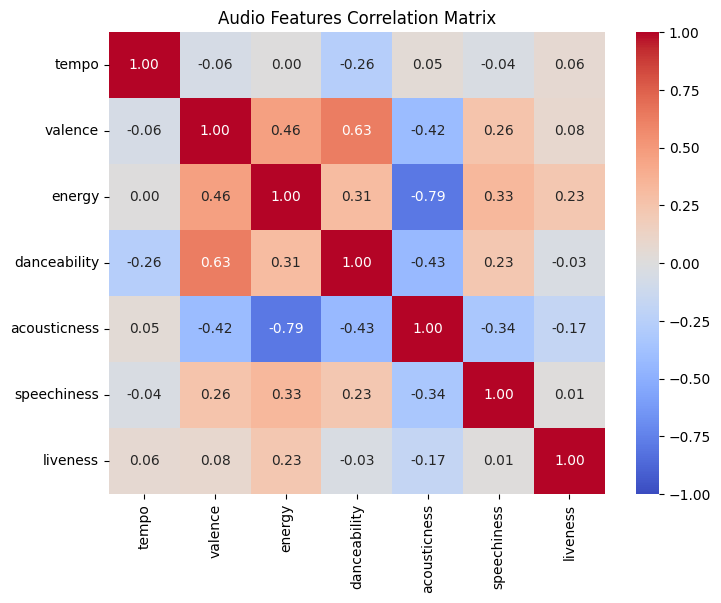

In [31]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 각 감정별 JSON 파일 경로 설정
json_files = {
    'anger': 'data/anger.json',
    'joy': 'data/joy.json',
    'neutral': 'data/neutral.json',
    'sadness': 'data/sadness.json'
}

# 데이터 수집
all_features = []

for label, file_path in json_files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        # JSON 파일의 값(피처)만 추출하여 리스트에 추가
        all_features.extend(list(data.values()))

# 오디오 피처 데이터를 numpy array로 변환하고 DataFrame으로 변환
feature_names = ['tempo', 'valence', 'energy', 'danceability', 'acousticness', 'speechiness', 'liveness']
audio_features_data = np.array(all_features)
df_features = pd.DataFrame(audio_features_data, columns=feature_names)

# 피처 스케일링 (0과 1 사이로 정규화)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_features)
df_scaled_features = pd.DataFrame(scaled_features, columns=feature_names)

# 상관 행렬 계산
correlation_matrix = df_scaled_features.corr()

# 상관 행렬 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Audio Features Correlation Matrix")
plt.show()


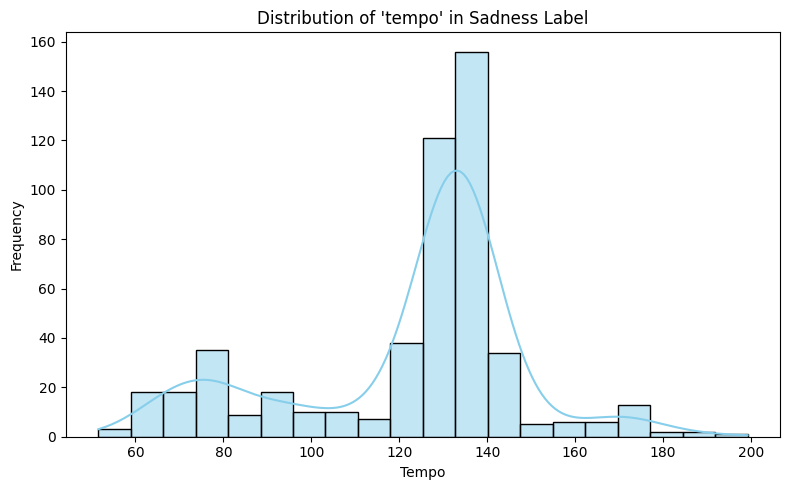

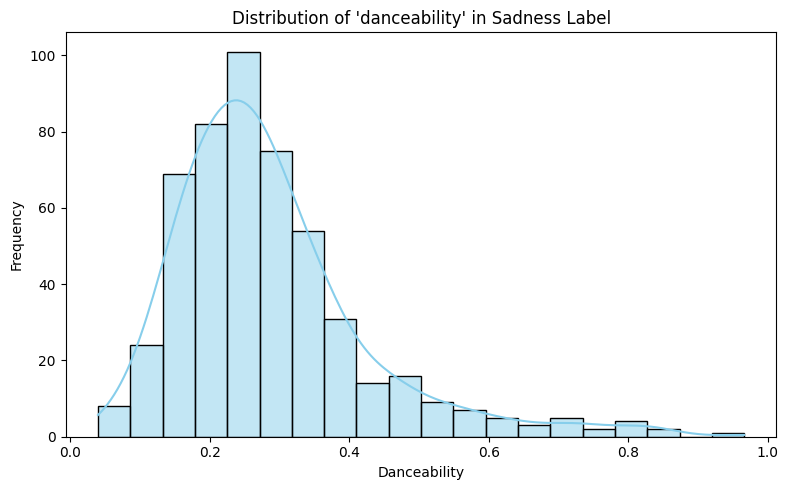

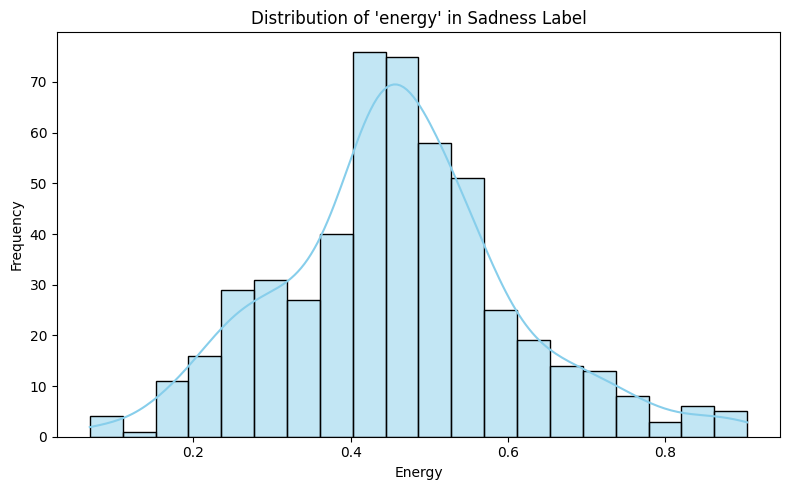

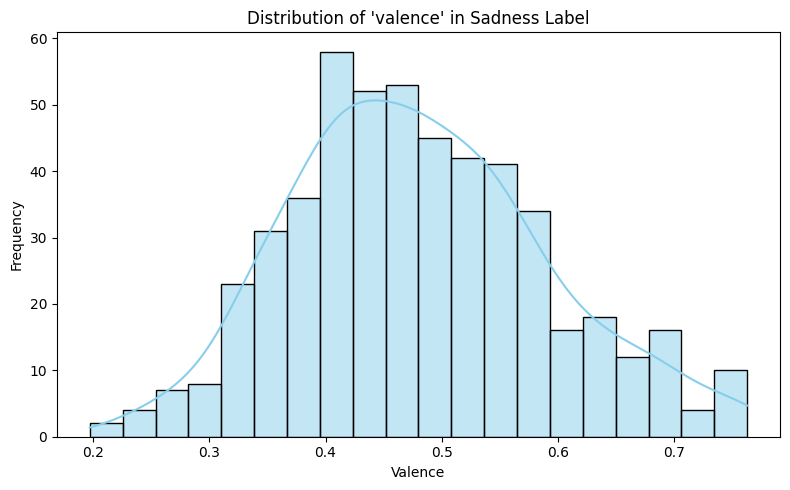

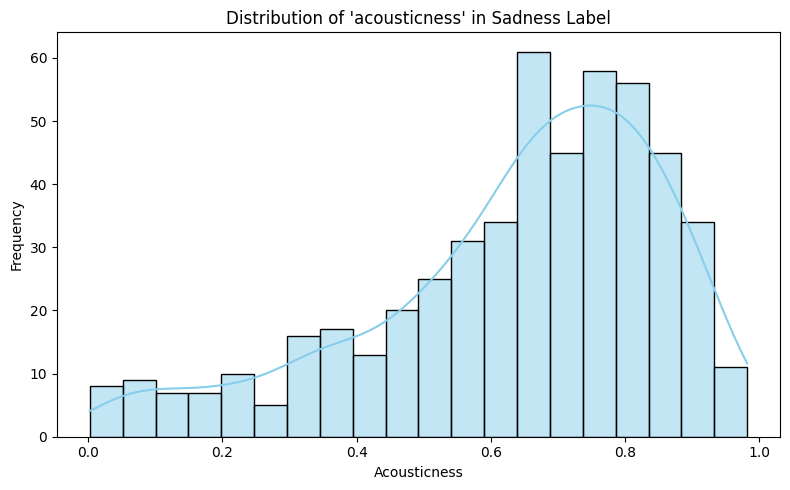

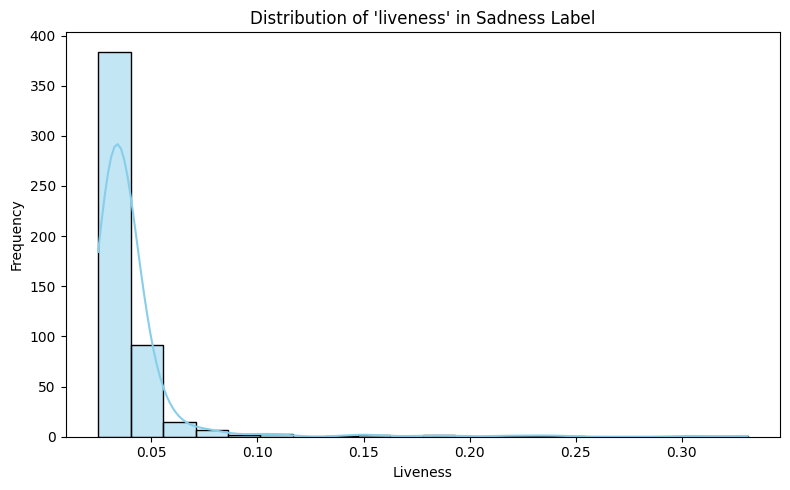

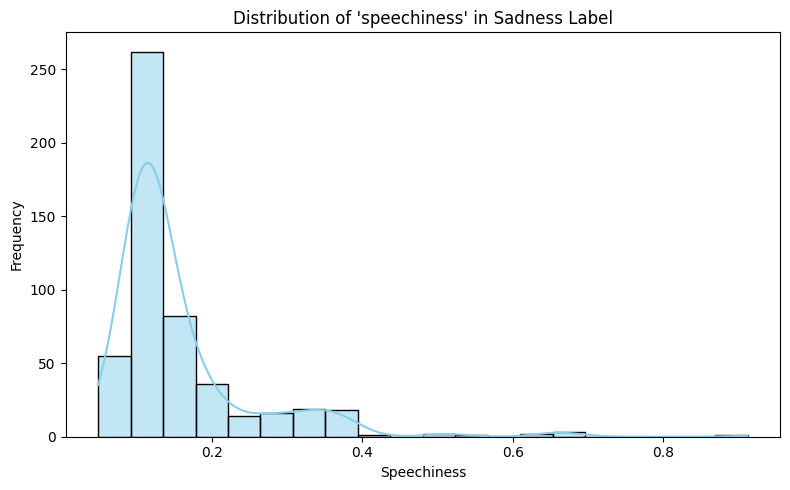

In [19]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# JSON 파일 경로 설정
json_files = {
    "anger": 'data/anger.json',
    "joy": 'data/joy.json',
    "neutral": 'data/neutral.json',
    "sadness": 'data/sadness.json'
}

# 특정 레이블 선택 (여기서 'anger'를 선택)
selected_label = "sadness"
file_path = json_files[selected_label]

# JSON 파일 읽기
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 데이터를 pandas DataFrame으로 변환
feature_names = ['tempo', 'danceability', 'energy', 'valence', 'acousticness', 'liveness', 'speechiness']
df = pd.DataFrame(data.values(), columns=feature_names)

# 피쳐별 분포 시각화
for feature in feature_names:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=20, color="skyblue")
    plt.title(f"Distribution of '{feature}' in {selected_label.capitalize()} Label")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


AttributeError: 'list' object has no attribute 'shape'